In [178]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import remove_small_objects, binary_dilation
import imageio

In [179]:
line_conf = np.load('line_detec_confidence_map.npy')
morph_conf = np.load('morph_conf.npy')
nn_conf = np.load('yhat_21.npy')

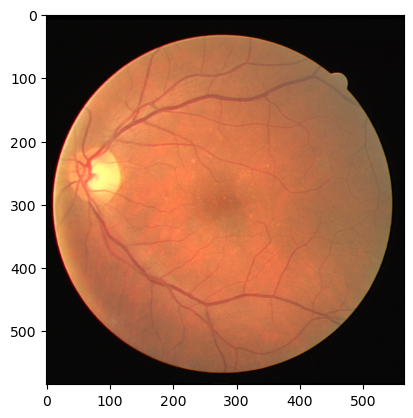

In [180]:
image = cv2.imread('../Drive/training/images/21_training.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [181]:
def combine_confidence_maps(*maps):
    combined_map = np.mean(np.array(maps), axis=0)
    return combined_map


In [182]:
def hybrid_vessel_segmentation(*maps, threshold = 80):
    combined_map = combine_confidence_maps(*maps)
    _, thresh_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    cleaned_image = remove_small_objects(thresh_img.astype(bool), min_size=100).astype(np.uint8) * 255
    return cleaned_image

In [183]:
line_conf = cv2.convertScaleAbs(line_conf, alpha=(255.0))
morph_conf = cv2.convertScaleAbs(morph_conf, alpha=(255.0))
nn_conf = cv2.convertScaleAbs(nn_conf, alpha=(255.0))

In [184]:
img = combine_confidence_maps(line_conf, morph_conf, nn_conf)

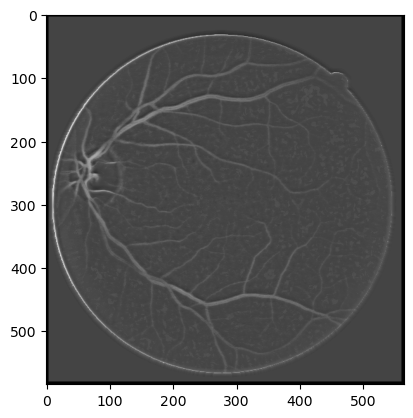

In [185]:
plt.imshow(img, cmap='gray')

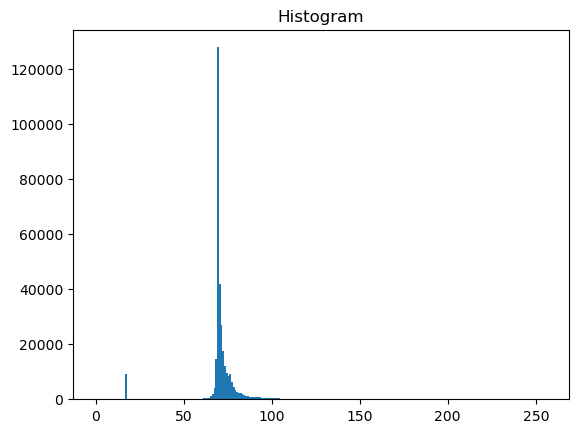

In [186]:
plt.hist(img.ravel(), bins=256, range=(0, 256))
plt.title('Histogram')
plt.show()

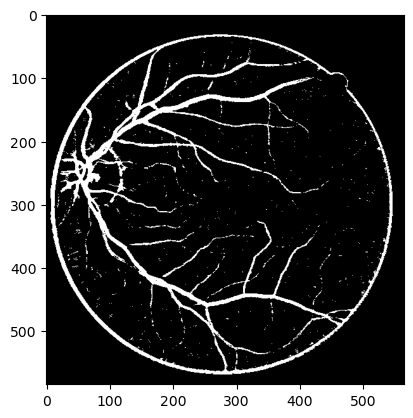

In [187]:
_, thresh_img = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY)
plt.imshow(thresh_img, cmap='gray')

In [188]:
final_img = hybrid_vessel_segmentation(img, threshold=77)

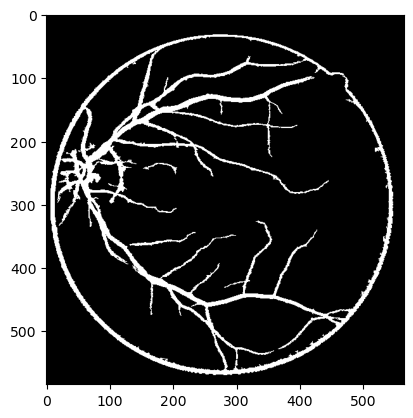

In [189]:
plt.imshow(final_img, cmap='gray')

In [190]:
def classify_pixels(hybrid_image, ground_truth):
    TP = np.logical_and(hybrid_image == 255, ground_truth == 255).astype(int) 
    FP = np.logical_and(hybrid_image == 255, ground_truth == 0).astype(int)
    FN = np.logical_and(hybrid_image == 0, ground_truth == 255).astype(int)
    TN = np.logical_and(hybrid_image == 0, ground_truth == 0).astype(int)
    
    comparison_image = np.zeros((*hybrid_image.shape, 3), dtype=np.uint8)
    comparison_image[TP == 1] = [0, 255, 0]
    comparison_image[FP == 1] = [255, 0, 0]
    comparison_image[FN == 1] = [0, 0, 255]
    
    eval_metrics = [TP, FP, FN, TN]
    
    return comparison_image, eval_metrics

(-0.5, 564.5, 583.5, -0.5)

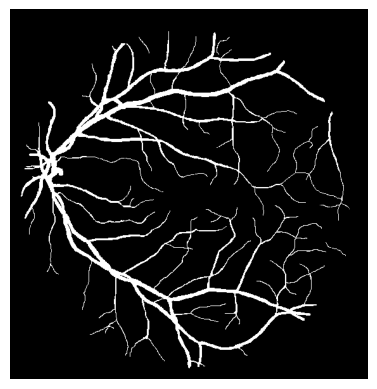

In [191]:
ground_truth_image = imageio.mimread('../Drive/training/1st_manual/21_manual1.gif')[0]
plt.imshow(ground_truth_image, cmap='gray')
plt.axis('off')

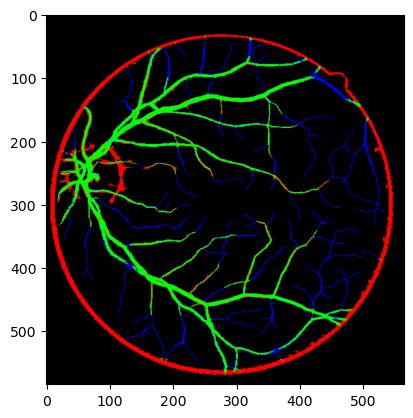

In [192]:
eval_metrics = []
classified_image, eval_metrics = classify_pixels(final_img, ground_truth_image)
plt.imshow(classified_image)

In [193]:
def modified_hybrid(line_conf, morph_conf, nn_conf, image, threshold=77):
    # Step 1: Extract the green channel
    green_channel = image[:, :, 1]

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    green_equalized = clahe.apply(green_channel)

    # Thresholding to create the mask
    _, bright_areas_mask = cv2.threshold(green_equalized, 200, 255, cv2.THRESH_BINARY)

    # Dilate the mask
    kernel = np.ones((11, 11), np.uint8)
    dilated_mask = binary_dilation(bright_areas_mask, kernel)
    
    # Get the combined confidence map
    combined_confidence_map = combine_confidence_maps(line_conf, morph_conf, nn_conf)
    
    # Replace masked areas with morphological results
    hybrid_result = np.where(dilated_mask, morph_conf, combined_confidence_map)
    
    # Threshold the result
    _, thresh_img = cv2.threshold(hybrid_result, threshold, 255, cv2.THRESH_BINARY)
    
    # Remove small objects
    cleaned_image = remove_small_objects(thresh_img.astype(bool), min_size=100).astype(np.uint8) * 255
    
    return cleaned_image

In [194]:
final_res = modified_hybrid(line_conf, morph_conf, nn_conf, image)

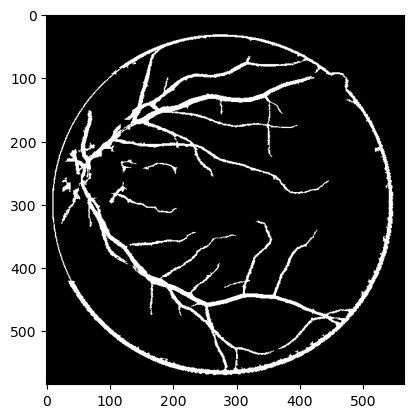

In [195]:
plt.imshow(final_res, cmap='gray')

In [196]:
TP = np.sum(eval_metrics[0])
FP = np.sum(eval_metrics[1])
FN = np.sum(eval_metrics[2])
TN = np.sum(eval_metrics[3])

accuracy = (TP + TN) / (TP + FP + FN + TN)

precision = TP / (TP + FP)

recall = TP / (TP + FN)


print(f"Hybrid Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Hybrid Accuracy: 0.9332
Precision: 0.5415
Recall: 0.6939


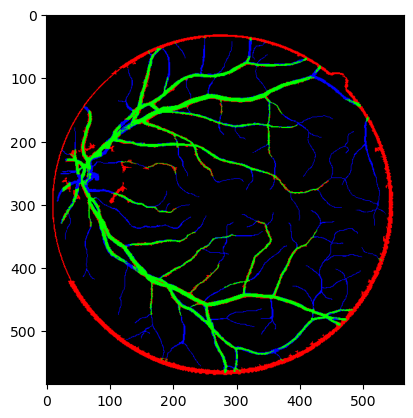

In [197]:
eval_metrics = []
classified_image, eval_metrics = classify_pixels(final_res, ground_truth_image)
plt.imshow(classified_image)

In [198]:
TP = np.sum(eval_metrics[0])
FP = np.sum(eval_metrics[1])
FN = np.sum(eval_metrics[2])
TN = np.sum(eval_metrics[3])

accuracy = (TP + TN) / (TP + FP + FN + TN)

precision = TP / (TP + FP)

recall = TP / (TP + FN)


print(f"Hybrid Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Hybrid Accuracy: 0.9385
Precision: 0.5789
Recall: 0.6487
